In [1]:
!pip install pyTigerGraph

     |████████████████████████████████| 10.2 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 8.9 MB/s eta 0:00:011
     |████████████████████████████████| 510 kB 10.9 MB/s eta 0:00:01


## Connect to a Synthea TigerGraph server


In [2]:
import getpass

server = 'https://yaniv.i.tgcloud.io'
password = getpass.getpass()

········


In [3]:
import pyTigerGraph as tg 

conn = tg.TigerGraphConnection(
    host=server, 
    graphname="synthea", 
    username="tigergraph",
    password=password,
)

shell = tg.Gsql(conn, client_version="2.6.0")

In [4]:
!ls -l $shell.jarLocation

total 1432
-rw-r--r--  1 ybenami  ybenami  671144 Jul 21 14:06 gsql_client.jar
-rw-r--r--  1 ybenami  ybenami    8518 Jul 21 14:06 my-cert.txt


In [5]:
#!rm -rf $shell.jarLocation

In [6]:
secret = shell.createSecret()
conn.getToken(secret=secret)

('qjv4m187po3f21abtoki1u94d5bemeh0', 1597950428, '2020-08-20 19:07:08')

In [7]:
query = '''
drop query get_all_patients
create query get_all_patients() for graph synthea{
    TYPEDEF TUPLE <description STRING, date DATETIME> CondTup;

    BagAccum <CondTup> @conditions;

    patients = {Patient.*};

    patients = select pat from patients:pat;

    x = select pat from patients:pat-(PATIENT_HAS_CONDITION)-Condition:cond
            accum pat.@conditions += CondTup(cond.description, cond.startDate);

    print patients;
}
install query get_all_patients
'''

print(shell.gsql(query))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
The query get_all_patients is dropped.
The query get_all_patients has been added!
Start installing queries, about 1 minute ...
get_all_patients query: curl -X GET 'https://127.0.0.1:9000/query/synthea/get_all_patients'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.

[=================================================================] 100% (1/1) 



In [8]:
query = conn.runInstalledQuery('get_all_patients', sizeLimit=10**10)

In [52]:
len(query[0]['patients'])

109321

In [88]:
%%writefile getFeatures.py

import numpy as np
import pandas as pd
from datetime import datetime
import math

def yaniv_to_ed_query(query):

    query[0]['people'] = query[0].pop('patients')

    for patient in query[0]['people']:
        patient['attributes']['people.dateOfBirth'] = patient['attributes'].pop('birth')
        patient['attributes']['people.dateOfDeath'] = patient['attributes'].pop('death')
        patient['attributes']['people.@gender'] = [(
            'F' if patient['attributes'].pop('gender') == 'female'
            else 'M')]
        patient['attributes']['people.@diagData'] = patient['attributes'].pop('@conditions')
        for condition in patient['attributes']['people.@diagData']:
            condition['diagnosisDate'] = condition.pop('date')
            condition['diagnosis'] = condition.pop('description')
        patient['attributes'].pop('name')
        patient['attributes'].pop('patient_id')
        
    return query


def get_conditions(query, startDate='1900-01-01', endDate='2019-12-31'):
        
    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    conditions = [
        condition['diagnosis']
        for patient in query[0]['people'] 
        for condition in patient['attributes']['people.@diagData']
        if (
            datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
            >= startDate
            and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
            <= endDate
        )
    ]

    conditions = pd.Series(conditions).value_counts()    

    return conditions


def get_live_patients(query, startDate='1900-01-01', endDate='2019-12-31'):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    patients = [
        patient['v_id'] 
        for patient in query[0]['people']
        if (
            datetime.strptime(
                patient['attributes']['people.dateOfBirth'], '%Y-%m-%d %H:%M:%S') 
            <= endDate
            and datetime.strptime(
                patient['attributes']['people.dateOfDeath'], '%Y-%m-%d %H:%M:%S')
            >= startDate
        )
    ]

    return patients

def make_age_groups(years = 5, top_year = 100):
    age_groups_ranges = [(i,min(i+years-1,top_year)) 
        for i in range(0, top_year, years)] + [(top_year, 140)]

    age_group_titles = [
        'Age {}-{}'.format(start, end) for start, end in age_groups_ranges]

    return age_groups_ranges, age_group_titles


def get_feature_vec(query, conditions, startDate, endDate, age_groups):

    startDate = datetime.strptime(startDate, '%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d')

    demog_df = pd.DataFrame([patient['attributes'] 
                             for patient in query[0]['people']])

    demog_df.index = [
        patient['v_id'] for patient in query[0]['people']
    ]

    demog_df = demog_df[[
        'people.@gender',
        'people.dateOfBirth',
        'people.dateOfDeath',
    ]]

    df = pd.DataFrame(
            np.zeros((len(demog_df.index), len(conditions.index))),
            index=demog_df.index, 
            columns=conditions.index,
        )

    for patient in query[0]['people']:

        patient_conditions = [
            condition['diagnosis'] 
            for condition in patient['attributes']['people.@diagData']
            if (
                datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S') 
                >= startDate
                and datetime.strptime(condition['diagnosisDate'], '%Y-%m-%d %H:%M:%S')
                <= endDate
                and condition['diagnosis'] in conditions
            )
        ]

        df.loc[patient['v_id'], patient_conditions ] = 1

    return concat_features(
        conditions_df=df, 
        demog_df=demog_df, 
        date=endDate, 
        age_groups=age_groups,
    )

def concat_features(conditions_df, demog_df, date, age_groups):

    dead_df = deceased(demog_df, date)
    gender_df = gender(demog_df)
    age_df = age_group_df(
        df = demog_df, 
        date_for_age = date,
        age_groups=age_groups,
    )
    
    return pd.concat([gender_df, dead_df, age_df, conditions_df], axis=1)


def age_group_df(df, date_for_age, age_groups):

    age_group_df = pd.DataFrame(
        np.zeros((len(df),len(age_groups[0]))),
        index=df.index, 
        columns=age_groups[1]
        )

    for i in df.index:
        age = math.floor(
            (date_for_age
            - datetime.strptime(df.loc[i,'people.dateOfBirth'], '%Y-%m-%d %H:%M:%S')
            ).days/365.25
        )

        for j, age_group in enumerate(age_groups[0]):
            if age >= age_group[0] and age <= age_group[1]:
                age_group_df.loc[i].iloc[j]=1

    return age_group_df


def deceased(df, date):

    dead = df['people.dateOfDeath'].apply(
        lambda x: 1.0 if (
            date - datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        ).days > 0 else 0.0
    )

    dead.name = 'Deceased'

    return dead


def gender(df):

    gender = df['people.@gender'].apply(
        lambda x: 1.0 if x[0]=='F' else 0.0
    )

    gender.name = 'Female'

    return gender

Overwriting getFeatures.py


In [9]:
import getFeatures
import importlib

importlib.reload(getFeatures)

<module 'getFeatures' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/getFeatures.py'>

In [10]:
query = getFeatures.yaniv_to_ed_query(query)

## Get the set of all conditions

In [375]:
%%writefile predictConditions.py
import getFeatures
import feature_weighted_mse
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import ttest_1samp    
from statsmodels.stats.multitest import multipletests

def predictConditions(query):
    
    print('Collecting all conditions:\n')
    
    conditions = getFeatures.get_conditions(
        query=query, startDate='2019-01-01', endDate='2020-12-31')
    
    print(conditions)
    

    patients = getFeatures.get_live_patients(
        query=query, startDate='2019-12-31', endDate='2019-12-31')
    
    print('\nNumber of patients', len(patients))
    

    age_groups = getFeatures.make_age_groups()
    
    print('\nAge groups\n', age_groups)
    

    print('\nCompute features: ')
    
    x_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2019-01-01', 
        endDate='2019-12-31', 
        age_groups=age_groups)

    print('\nx_df.shape ', x_df.shape)
    
    print('\nCompute labels: ')
    
    y_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2020-01-01', 
        endDate='2020-12-31', 
        age_groups=age_groups)
    
    print('\ny_df.shape ', y_df.shape)
    

    train, test = train_test_split(patients, test_size=0.25, random_state=42)
    
    x_train_df = x_df.loc[train]
    y_train_df = y_df.loc[train]
    x_test_df = x_df.loc[test]
    y_test_df = y_df.loc[test]
    
    print('\n\nTrain set:', len(train), 'Test set: ', len(test))
    
    print(
        '\n\nSorted x_train means:\n\n',
        x_train_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_train means:\n\n',
        y_train_df.mean().sort_values(ascending=False)
    )

    filter_below = 20
    print('\nFiltereing conditions with less than {} cases:'.format(filter_below))
    
    x_drop_list = ( 
        set(x_train_df.columns[x_train_df.sum() < filter_below])
        | set(x_test_df.columns[x_train_df.sum() < filter_below])
    )

    x_train_df = x_train_df.drop(x_drop_list, axis=1)
    x_test_df = x_test_df.drop(x_drop_list, axis=1)

    y_drop_list = ( 
        set(y_train_df.columns[y_train_df.sum() < filter_below])
        | set(y_test_df.columns[y_train_df.sum() < filter_below])
    )

    y_train_df = y_train_df.drop(y_drop_list, axis=1)
    y_test_df = y_test_df.drop(y_drop_list, axis=1)

    print(
        '\n\nSorted x_train means:\n\n',
        x_train_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_train means:\n\n\n\n',
        y_train_df.mean().sort_values(ascending=False)
    )
    
    print(
        '\n\nSorted x_test means:\n\n',
        x_test_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_test means:\n\n\n\n',
        y_test_df.mean().sort_values(ascending=False)
    )

    y_weights = 1 / (y_train_df.var() + 10e-7) / y_train_df.shape[-1]
    
    print(
        '\n',
        pd.DataFrame(
            [y_train_df.var(), y_weights],
             index=['y_train var', 'y_weights']
        ).transpose()
    )
    
    

    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #1 - y means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=y_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )
    
    

    from sklearn.model_selection import RepeatedKFold

    n_splits = 4
    n_repeats = 2
    alpha=0.0001
    
    print('\nTrain linear model using Lasso alpha {} {}-fold CV repeated {} times.\n'.format(
        alpha, n_splits, n_repeats,
    ))
    
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    models=[]
    history=[]
    performance=[]
    
    i=0
    for train_index, validate_index in rkf.split(x_train_df):
        
        i += 1
        print('\n\nFold {} out of {}\n\n'.format(i, n_splits*n_repeats))
        
        x_train, x_validate = x_train_df.iloc[train_index], x_train_df.iloc[validate_index]
        y_train, y_validate = y_train_df.iloc[train_index], y_train_df.iloc[validate_index]
    
        inputs = keras.layers.Input(shape=x_train_df.shape[1])
        outputs = keras.layers.Dense(
            units=y_train_df.shape[1], 
            kernel_regularizer=keras.regularizers.l1(l=alpha),
        )(inputs)
        
        models.append(keras.Model(inputs=inputs, outputs=outputs))

        models[-1].compile(loss=wmse, optimizer=keras.optimizers.Adam())

        history.append(models[-1].fit(
            x=x_train,
            y=y_train,
            batch_size=128,
            epochs=1000,
            validation_data=(x_validate, y_validate),
            callbacks=[
                keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            ]
        ))
    
        print('\nEvaluate on test set:\n')
        performance.append(models[-1].evaluate(x=x_test_df, y=y_test_df))
        print(performance[-1],'\n')

    from scipy.stats import ttest_1samp    
    from statsmodels.stats.multitest import multipletests
    
    constant_df = pd.DataFrame(
        np.array([model.layers[1].get_weights()[1] for model in models]).transpose(), 
        index=y_train_df.columns, 
        columns=['Fold {}'.format(i) for i in range(1, 1+n_splits*n_repeats)],
    )
        
    constant_mean = constant_df.mean(axis=1)
    constant_mean.name = 'mean'
    
    constant_std = constant_df.std(axis=1, ddof=1)
    constant_std.name = 'std'
    
    constant_p_value = constant_df.apply(lambda x: ttest_1samp(x, 0)[1], axis=1)
    constant_p_value.name = 'p-value'
    
    constant_df = pd.concat([constant_mean, constant_std, constant_p_value], axis=1)

    constant_df['FDR adj p-value'] = multipletests(constant_p_value, method='fdr_bh')[1]
    
    constant_df.to_csv('constant.csv')
    print('\n\nConstants:\n\n ', constant_df.head(30))


    coef_mat = np.array([model.layers[1].get_weights()[0] for model in models]).transpose((1, 2, 0))
    
    coef_df = pd.DataFrame(
        [[json.dumps(coef_mat[i,j].tolist()) 
          for j in range(coef_mat.shape[1])] 
         for i in range(coef_mat.shape[0])], 
        columns=y_train_df.columns, 
        index=x_train_df.columns
    ).transpose()
    
    coef_mean = coef_df.applymap(lambda x: np.mean(json.loads(x)))
    coef_mean.to_csv('coef_mean.csv')
    
    coef_std = coef_df.applymap(lambda x: np.std(json.loads(x), ddof=1))
    coef_std.to_csv('coef_std.csv')
    
    coef_p_value = coef_df.applymap(lambda x: ttest_1samp(json.loads(x), 0)[1])
    coef_p_value.to_csv('coef_p_value.csv')
    
    coef_p_value_adj = multipletests(
        coef_p_value.values.reshape((-1,)), 
        method='fdr_bh')[1].reshape(coef_p_value.shape)
    
    coef_p_value_adj = pd.DataFrame(
        coef_p_value_adj, index=y_train_df.columns, columns=x_train_df.columns)
    coef_p_value_adj.to_csv('coef_p_value_adj.csv')

    nonzero = coef_p_value_adj.applymap(lambda x: x <= 0.05).values.nonzero()

    tuples = [(
        coef_df.index[i], 
        coef_df.columns[j], 
        coef_mean.iloc[i,j],
        coef_std.iloc[i,j],
        coef_p_value.iloc[i,j],
        coef_p_value_adj.iloc[i,j],
    ) for i,j in zip(nonzero[0],nonzero[1])]
    
    coef_df = pd.DataFrame(tuples, columns=['y','x','mean', 'std', 'p-value', 'FDR adj p-value'])
    coef_df.to_csv('coef.csv', index=False)
    print(coef_df.head(30))

    f, ax = plt.subplots(figsize=(80, 50))
    ax = sns.heatmap(
        coef_mean, 
        xticklabels=x_train_df.columns, 
        yticklabels=y_train_df.columns,
        center=0.0,
        cmap='seismic',
    )
    
    plt.savefig('linear_coefs.png')

Overwriting predictConditions.py


In [376]:
import predictConditions
import importlib

importlib.reload(predictConditions)

<module 'predictConditions' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/predictConditions.py'>


Suspected COVID-19                                      81485
COVID-19                                                78851
Fever (finding)                                         72574
Cough (finding)                                         55183
Loss of taste (finding)                                 41275
                                                        ...  
Lupus erythematosus                                         1
Cystic Fibrosis                                             1
Chronic paralysis due to lesion of spinal cord              1
History of amputation of foot (situation)                   1
Blindness due to type 2 diabetes mellitus (disorder)        1
Length: 173, dtype: int64

Number of patients 92258

Age groups
 ([(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79), (80, 84), (85, 89), (90, 94), (95, 99), (100, 140)], ['Age 0-4', 'Age 5-9', 'Age 10-14', 'Age 

51894/51894 [==============================] - 1s 11us/sample - loss: 0.8849 - val_loss: 0.8941
Epoch 12/1000
51894/51894 [==============================] - 1s 12us/sample - loss: 0.8847 - val_loss: 0.8926
Epoch 13/1000
51894/51894 [==============================] - 1s 19us/sample - loss: 0.8843 - val_loss: 0.8933
Epoch 14/1000
51894/51894 [==============================] - 1s 11us/sample - loss: 0.8843 - val_loss: 0.8937
Epoch 15/1000
51894/51894 [==============================] - 1s 16us/sample - loss: 0.8841 - val_loss: 0.8927
Epoch 16/1000
51894/51894 [==============================] - 1s 12us/sample - loss: 0.8839 - val_loss: 0.8924
Epoch 17/1000
51894/51894 [==============================] - 1s 16us/sample - loss: 0.8838 - val_loss: 0.8931
Epoch 18/1000
51894/51894 [==============================] - 1s 12us/sample - loss: 0.8840 - val_loss: 0.8924
Epoch 19/1000
51894/51894 [==============================] - 1s 11us/sample - loss: 0.8840 - val_loss: 0.8923
Epoch 20/1000
51894/5189

51895/51895 [==============================] - 1s 10us/sample - loss: 0.8926 - val_loss: 0.8902
Epoch 6/1000
51895/51895 [==============================] - 1s 11us/sample - loss: 0.8905 - val_loss: 0.8881
Epoch 7/1000
51895/51895 [==============================] - 1s 11us/sample - loss: 0.8889 - val_loss: 0.8884
Epoch 8/1000
51895/51895 [==============================] - 1s 11us/sample - loss: 0.8882 - val_loss: 0.8868
Epoch 9/1000
51895/51895 [==============================] - 1s 16us/sample - loss: 0.8876 - val_loss: 0.8869
Epoch 10/1000
51895/51895 [==============================] - 1s 21us/sample - loss: 0.8872 - val_loss: 0.8863
Epoch 11/1000
51895/51895 [==============================] - 1s 20us/sample - loss: 0.8871 - val_loss: 0.8860
Epoch 12/1000
51895/51895 [==============================] - 1s 15us/sample - loss: 0.8868 - val_loss: 0.8853
Epoch 13/1000
51895/51895 [==============================] - 1s 12us/sample - loss: 0.8865 - val_loss: 0.8857
Epoch 14/1000
51895/51895 [=

51895/51895 [==============================] - 1s 16us/sample - loss: 0.9003 - val_loss: 0.8996
Epoch 4/1000
51895/51895 [==============================] - 1s 18us/sample - loss: 0.8936 - val_loss: 0.8957
Epoch 5/1000
51895/51895 [==============================] - 1s 18us/sample - loss: 0.8906 - val_loss: 0.8926
Epoch 6/1000
51895/51895 [==============================] - 1s 17us/sample - loss: 0.8885 - val_loss: 0.8914
Epoch 7/1000
51895/51895 [==============================] - 1s 19us/sample - loss: 0.8873 - val_loss: 0.8903
Epoch 8/1000
51895/51895 [==============================] - 1s 19us/sample - loss: 0.8864 - val_loss: 0.8907
Epoch 9/1000
51895/51895 [==============================] - 1s 12us/sample - loss: 0.8863 - val_loss: 0.8901
Epoch 10/1000
51895/51895 [==============================] - 1s 15us/sample - loss: 0.8861 - val_loss: 0.8899
Epoch 11/1000
51895/51895 [==============================] - 1s 19us/sample - loss: 0.8858 - val_loss: 0.8896
Epoch 12/1000
51895/51895 [===

            y                                            x      mean  \
0      Female                                       Female  0.993259   
1    Deceased                                       Female -0.012065   
2    Deceased                                      Age 0-4 -0.031132   
3    Deceased                                      Age 5-9 -0.030721   
4    Deceased                                    Age 10-14 -0.030616   
5    Deceased                                    Age 15-19 -0.032264   
6    Deceased                                    Age 20-24 -0.025157   
7    Deceased                                    Age 25-29 -0.021368   
8    Deceased                                    Age 30-34 -0.024226   
9    Deceased                                    Age 35-39 -0.024128   
10   Deceased                                    Age 40-44 -0.021165   
11   Deceased                                    Age 45-49 -0.021029   
12   Deceased                                    Age 60-64  0.01

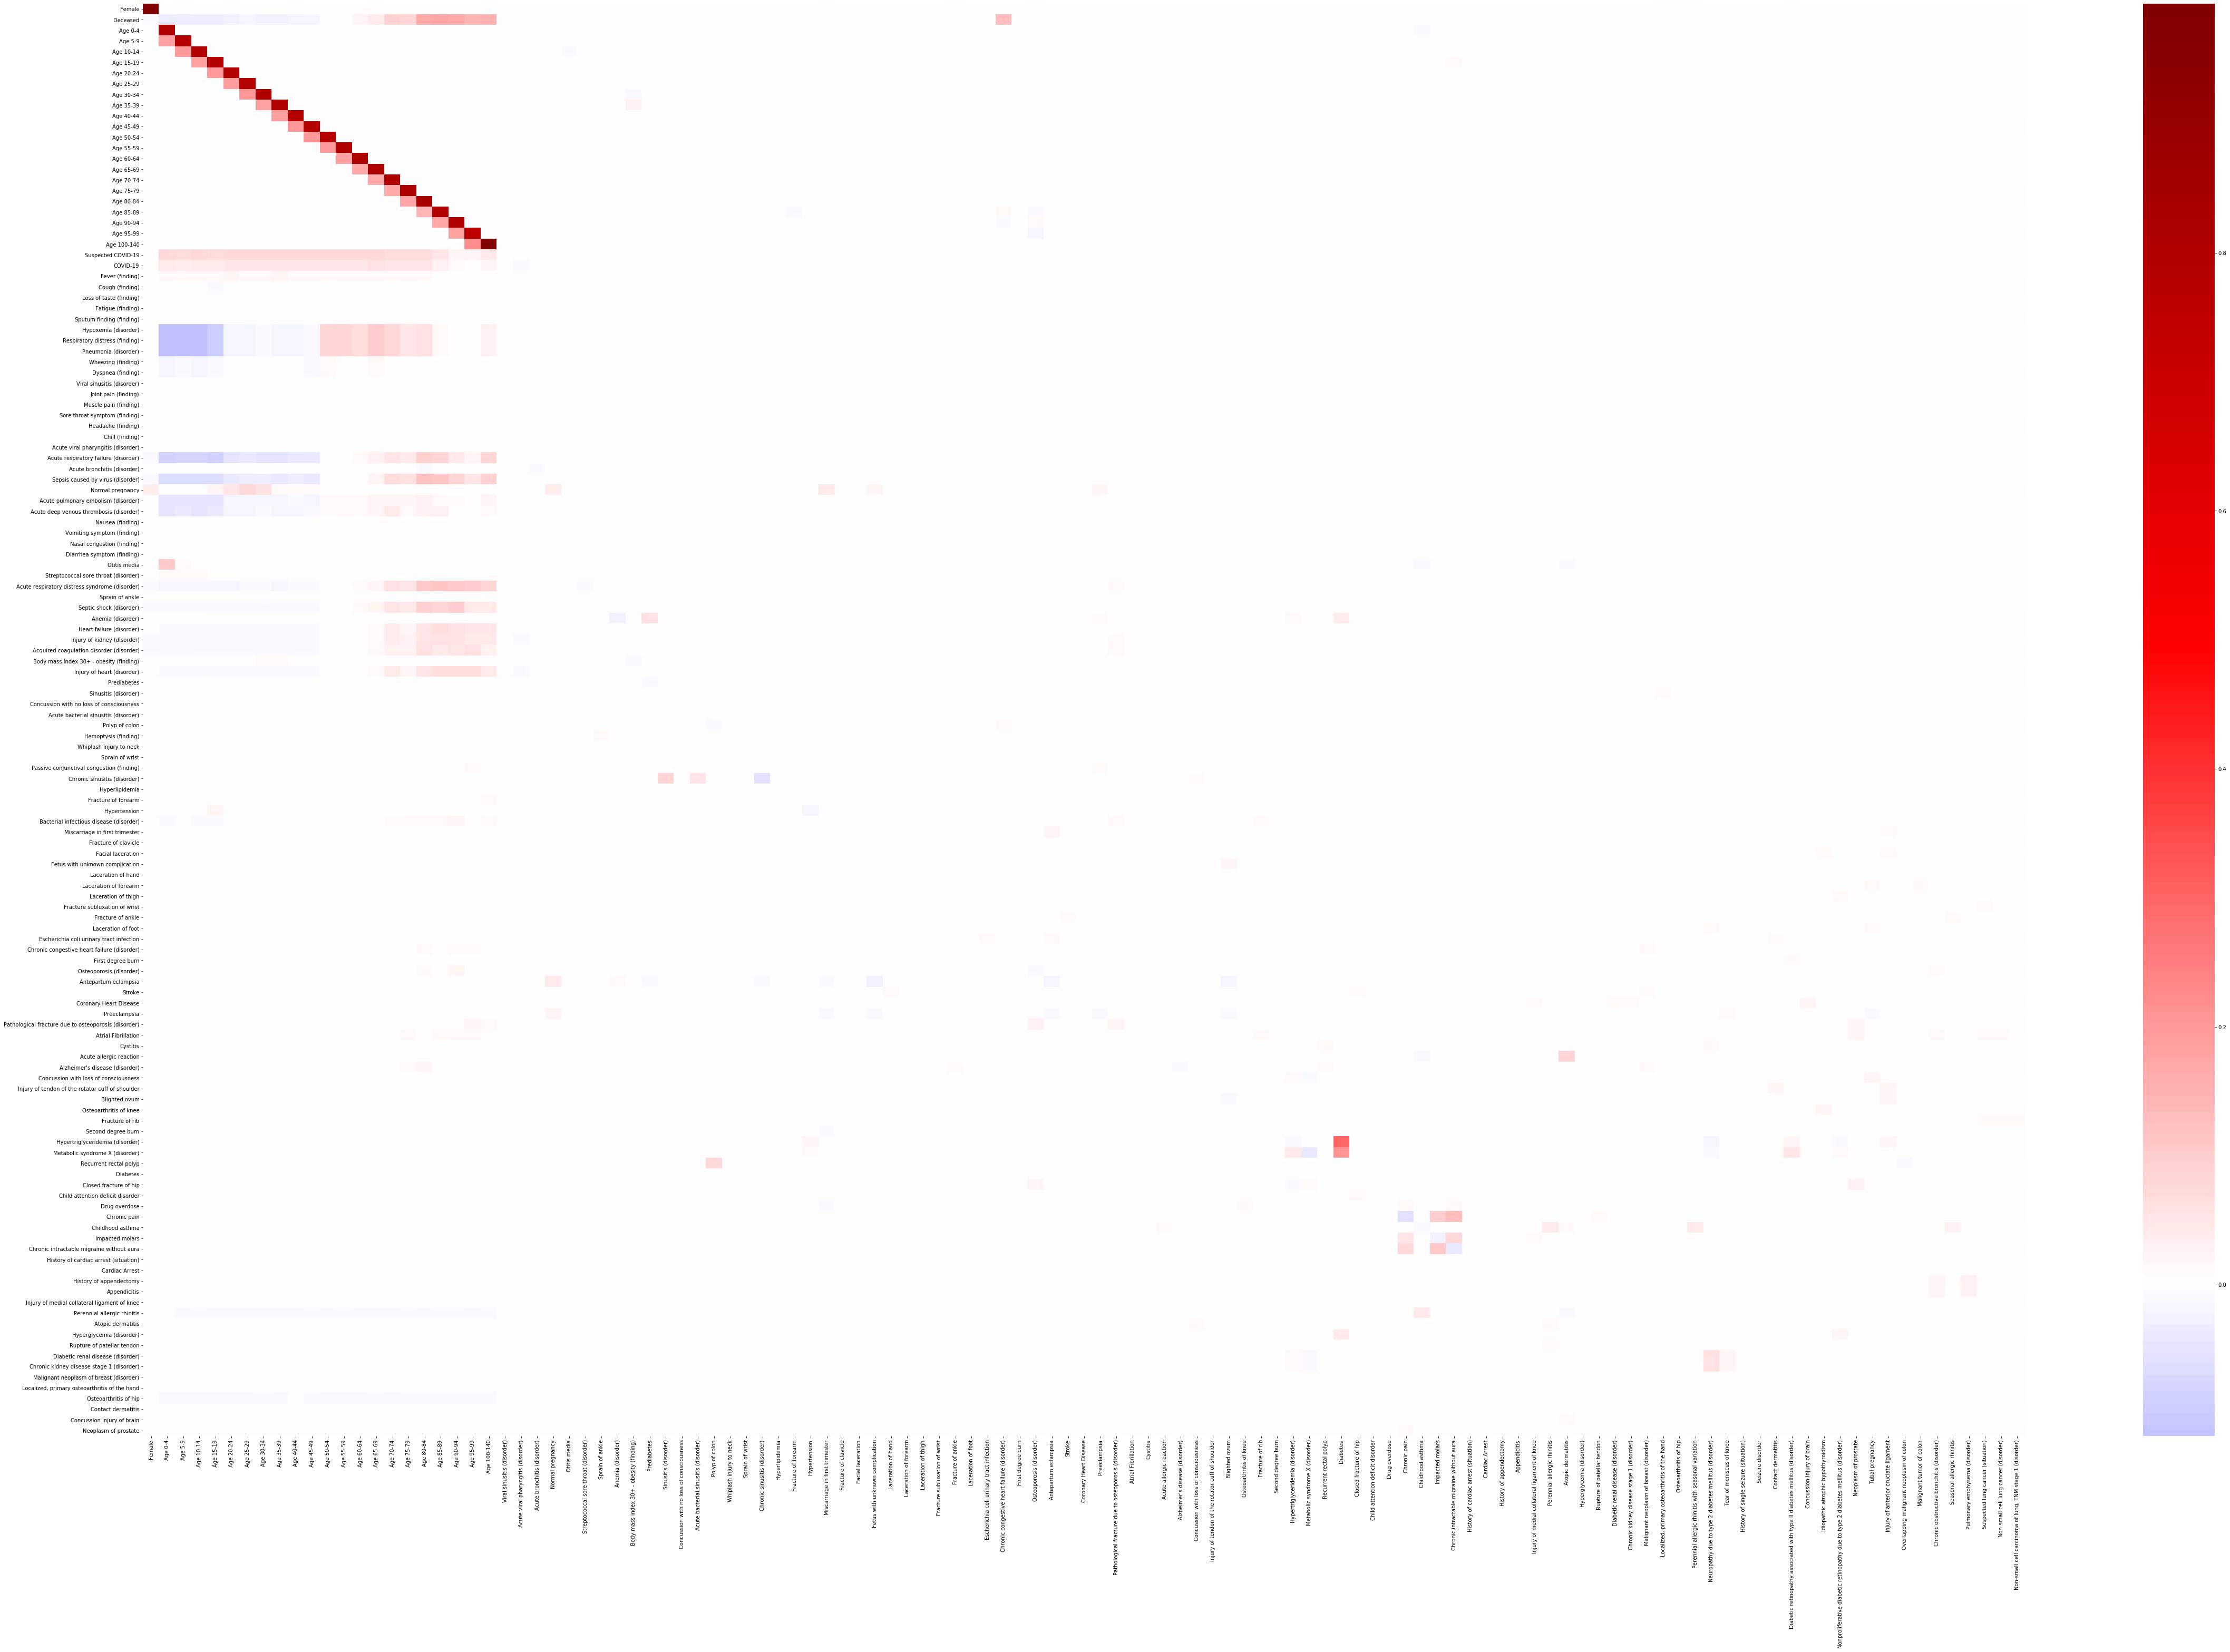

In [377]:
predictConditions.predictConditions(query)

In [51]:
%%writefile feature_weighted_mse.py
import tensorflow as tf

def make_feature_weighted_mse(feature_weights):
    
    feature_weights = tf.reshape(tf.cast(feature_weights, 'float32'), (-1,1))
    
    def feature_weighted_mse(y_true, y_pred):
        
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        return tf.linalg.matmul(tf.square(y_true - y_pred), feature_weights)
        #tf.reduce_sum(
    
    return feature_weighted_mse

Overwriting feature_weighted_mse.py


In [52]:
import feature_weighted_mse

importlib.reload(feature_weighted_mse)

<module 'feature_weighted_mse' from '/Users/ybenami/EasyAsPie.ai/MedGraphML/feature_weighted_mse.py'>

In [13]:
import getFeatures
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import ttest_1samp    
from statsmodels.stats.multitest import multipletests

In [ ]:
    print('Collecting all conditions:\n')
    
    conditions = getFeatures.get_conditions(
        query=query, startDate='2019-01-01', endDate='2020-12-31')
    
    print(conditions)
    

    patients = getFeatures.get_live_patients(
        query=query, startDate='2019-12-31', endDate='2019-12-31')
    
    print('\nNumber of patients', len(patients))
    

    age_groups = getFeatures.make_age_groups()
    
    print('\nAge groups\n', age_groups)
    

    print('\nCompute features: ')
    
    x_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2019-01-01', 
        endDate='2019-12-31', 
        age_groups=age_groups)

    print('\nx_df.shape ', x_df.shape)
    
    print('\nCompute labels: ')
    
    y_df = getFeatures.get_feature_vec(
        query,
        conditions=conditions,
        startDate='2020-01-01', 
        endDate='2020-12-31', 
        age_groups=age_groups)
    
    print('\ny_df.shape ', y_df.shape)
    

    train, test = train_test_split(patients, test_size=0.25, random_state=42)
    
    x_train_df = x_df.loc[train]
    y_train_df = y_df.loc[train]
    x_test_df = x_df.loc[test]
    y_test_df = y_df.loc[test]
    
    print('\n\nTrain set:', len(train), 'Test set: ', len(test))
    
    print(
        '\n\nSorted x_train means:\n\n',
        x_train_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_train means:\n\n',
        y_train_df.mean().sort_values(ascending=False)
    )

    filter_below = 20
    print('\nFiltereing conditions with less than {} cases:'.format(filter_below))
    
    x_drop_list = ( 
        set(x_train_df.columns[x_train_df.sum() < filter_below])
        | set(x_test_df.columns[x_train_df.sum() < filter_below])
    )

    x_train_df = x_train_df.drop(x_drop_list, axis=1)
    x_test_df = x_test_df.drop(x_drop_list, axis=1)

    y_drop_list = ( 
        set(y_train_df.columns[y_train_df.sum() < filter_below])
        | set(y_test_df.columns[y_train_df.sum() < filter_below])
    )

    y_train_df = y_train_df.drop(y_drop_list, axis=1)
    y_test_df = y_test_df.drop(y_drop_list, axis=1)

    print(
        '\n\nSorted x_train means:\n\n',
        x_train_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_train means:\n\n\n\n',
        y_train_df.mean().sort_values(ascending=False)
    )
    
    print(
        '\n\nSorted x_test means:\n\n',
        x_test_df.mean().sort_values(ascending=False), 
        '\n\nSorted y_test means:\n\n\n\n',
        y_test_df.mean().sort_values(ascending=False)
    )

    y_weights = 1 / (y_train_df.var() + 10e-7) / y_train_df.shape[-1]
    
    print(
        '\n',
        pd.DataFrame(
            [y_train_df.var(), y_weights],
             index=['y_train var', 'y_weights']
        ).transpose()
    )
    
    

    wmse = feature_weighted_mse.make_feature_weighted_mse(y_weights)
    
    print(
        '\nBasic benchmark #1 - y means\n', 
        'Train loss',
        wmse(
            y_true=y_train_df.values, 
            y_pred=y_train_df.values.mean(axis=0)
        ).numpy().mean(),
    )
    
    

    from sklearn.model_selection import RepeatedKFold

    n_splits = 4
    n_repeats = 2
    alpha=0.0001
    
    print('\nTrain linear model using Lasso alpha {} {}-fold CV repeated {} times.\n'.format(
        alpha, n_splits, n_repeats,
    ))
    
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    models=[]
    history=[]
    performance=[]
    
    i=0
    for train_index, validate_index in rkf.split(x_train_df):
        
        i += 1
        print('\n\nFold {} out of {}\n\n'.format(i, n_splits*n_repeats))
        
        x_train, x_validate = x_train_df.iloc[train_index], x_train_df.iloc[validate_index]
        y_train, y_validate = y_train_df.iloc[train_index], y_train_df.iloc[validate_index]
    
        inputs = keras.layers.Input(shape=x_train_df.shape[1])
        outputs = keras.layers.Dense(
            units=y_train_df.shape[1], 
            kernel_regularizer=keras.regularizers.l1(l=alpha),
        )(inputs)
        
        models.append(keras.Model(inputs=inputs, outputs=outputs))

        models[-1].compile(loss=wmse, optimizer=keras.optimizers.Adam())

        history.append(models[-1].fit(
            x=x_train,
            y=y_train,
            batch_size=128,
            epochs=1000,
            validation_data=(x_validate, y_validate),
            callbacks=[
                keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            ]
        ))
    
        print('\nEvaluate on test set:\n')
        performance.append(models[-1].evaluate(x=x_test_df, y=y_test_df))
        print(performance[-1],'\n')
    
    constant_df = pd.DataFrame(
        np.array([model.layers[1].get_weights()[1] for model in models]).transpose(), 
        index=y_train_df.columns, 
        columns=['Fold {}'.format(i) for i in range(1, 1+n_splits*n_repeats)],
    )
        
    constant_mean = constant_df.mean(axis=1)
    constant_mean.name = 'mean'
    
    constant_std = constant_df.std(axis=1, ddof=1)
    constant_std.name = 'std'
    
    constant_p_value = constant_df.apply(lambda x: ttest_1samp(x, 0)[1], axis=1)
    constant_p_value.name = 'p-value'
    
    constant_df = pd.concat([constant_mean, constant_std, constant_p_value], axis=1)

    constant_df['FDR adj p-value'] = multipletests(constant_p_value, method='fdr_bh')[1]
    
    constant_df.to_csv('constant.csv')
    print('\n\nConstants:\n\n ', constant_df.head(30))


    coef_mat = np.array([model.layers[1].get_weights()[0] for model in models]).transpose((1, 2, 0))
    
    coef_df = pd.DataFrame(
        [[json.dumps(coef_mat[i,j].tolist()) 
          for j in range(coef_mat.shape[1])] 
         for i in range(coef_mat.shape[0])], 
        columns=y_train_df.columns, 
        index=x_train_df.columns
    ).transpose()
    
    coef_mean = coef_df.applymap(lambda x: np.mean(json.loads(x)))
    coef_mean.to_csv('coef_mean.csv')
    
    coef_std = coef_df.applymap(lambda x: np.std(json.loads(x), ddof=1))
    coef_std.to_csv('coef_std.csv')
    
    coef_p_value = coef_df.applymap(lambda x: ttest_1samp(json.loads(x), 0)[1])
    coef_p_value.to_csv('coef_p_value.csv')
    
    coef_p_value_adj = multipletests(
        coef_p_value.values.reshape((-1,)), 
        method='fdr_bh')[1].reshape(coef_p_value.shape)
    
    coef_p_value_adj = pd.DataFrame(
        coef_p_value_adj, index=y_train_df.columns, columns=x_train_df.columns)
    coef_p_value_adj.to_csv('coef_p_value_adj.csv')

    nonzero = coef_p_value_adj.applymap(lambda x: x <= 0.05).values.nonzero()

    tuples = [(
        coef_df.index[i], 
        coef_df.columns[j], 
        coef_mean.iloc[i,j],
        coef_std.iloc[i,j],
        coef_p_value.iloc[i,j],
        coef_p_value_adj.iloc[i,j],
    ) for i,j in zip(nonzero[0],nonzero[1])]
    
    coef_df = pd.DataFrame(tuples, columns=['y','x','mean', 'std', 'p-value', 'FDR adj p-value'])
    coef_df.to_csv('coef.csv', index=False)
    print(coef_df.head(30))

    f, ax = plt.subplots(figsize=(80, 50))
    ax = sns.heatmap(
        coef_mean, 
        xticklabels=x_train_df.columns, 
        yticklabels=y_train_df.columns,
        center=0.0,
        cmap='seismic',
    )
    
    plt.savefig('linear_coefs.png')